In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi, log, gcd
import numpy.matlib
%matplotlib notebook

In [2]:
def get_K(d): 
    import numpy as np
    import numpy.matlib
    Sniter = np.array(range(d))
    Sniter = np.matlib.repmat(Sniter,d,1)
    Sniter = Sniter.reshape((1,d**2))
    Smiter = np.array(range(d))
    Smiter = np.matlib.repmat(Smiter,d,1)
    Smiter = Smiter.T.reshape((1,d**2))

    # starting with all operators except (0,0)
    Sniter_all = Sniter[0][1:]
    Smiter_all = Smiter[0][1:]

    Sniter = [1] + [ii for ii in range(d)]
    Smiter = [0] + [1 for ii in range(d)]

    op_All = [(Smiter_all[ii], Sniter_all[ii]) for ii in range(len(Sniter_all))]
    op_Current = [(Sniter[ii], Smiter[ii]) for ii in range(d)]
    
    n_eigVals = [d/np.gcd(W[0], np.gcd(W[1], d)) for W in op_All]
    #for ii, ee in zip(op_All, n_eigVals):
    #    print(ii, ee)
        
    op_tempKept = [op_All[ii] for ii in range(len(op_All)) if n_eigVals[ii] == d] # all full-rank operators
    
    op_finalKept = [op_tempKept[0]]
    for W in op_tempKept:
        L = [(K[0]*W[1] - K[1]*W[0])%d for K in op_finalKept]
        if 0 not in L:
            op_finalKept.append(W)
        #print(op_finalKept)
    
    #print(len(op_finalKept))
    Sniter = [W[0] for W in op_finalKept]
    Smiter = [W[1] for W in op_finalKept]
    #print(Sniter)



    eigRel = np.zeros((len(Sniter),d**2))
    for kk in range(len(Sniter)):
        appOp = 0;
        for nn in range(d):
            for mm in range(d):
                eigRel[kk,appOp] = (Smiter[kk]*nn - Sniter[kk]*mm)%d#(mm*g - nn*t)%d
                appOp +=1
    eig_Rel = {(Sniter[ii], Smiter[ii]): list(eigRel[ii]) for ii in range(len(Sniter))}


    idx_opers = list(eig_Rel.keys()) # indices of Weyl operators generators of input states
    out_rels = list(eig_Rel.values()) # corresponding output relations
    rel_matrix = np.matrix([np.array(row)==kk for row in out_rels for kk in range(d)], dtype = int)
    return(idx_opers, rel_matrix)

In [3]:
def eig_e_corr(d,rho):
    """Returns normalized eigenvalues of d^2 x d^2 dimensional exponential correlation matrix with correlation coefficient rho"""
    ec_Mat = np.zeros((d**2,d**2))
    for x in range(0,d**2):
        for y in range(0,d**2):
            ec_Mat[x,y] = rho**(abs(x - y))
    eig_e = np.linalg.eig(ec_Mat)
    eig_e = eig_e[0]/np.sum(eig_e[0])
    return(eig_e)

def DWC_tom_fast(AA):
    import numpy as np
    exp_obs,N, rel_matrix, rel_inv, pp,d = AA[0], AA[1], AA[2], AA[3], AA[4], AA[5]
    N_tom = round(N/(len(rel_matrix)/d))
    o_freq = [] # observed
    for kk in exp_obs:
        ideal = np.array(kk)
        freq = np.random.multinomial(N_tom, (1 - pp)*ideal + pp*np.ones(ideal.size)/d)/N_tom
        o_freq.extend(list(freq))
    o_freq = np.matrix(o_freq).T
    x_obs = rel_inv*o_freq#, resid, rank, s = np.linalg.lstsq(rel_matrix, o_freq, rcond = None)
    return x_obs

def empVar(AA):
    import numpy as np
    x_obs, M, N_vals, kkk = AA[0], AA[1], AA[2], AA[3]
    emp_var = np.var([[x_obs[ii+kk*M][kkk].tolist()[0][0] for ii in range(M)] for kk in range(len(N_vals))], axis = 1)
    return emp_var

def mmse(AA):
    import numpy as np
    x_obs, M, N_vals, kkk, aaa = AA[0], AA[1], AA[2], AA[3], AA[4]
    mse_val = np.mean([[(x_obs[ii+kk*M][kkk].tolist()[0][0] - aaa[kkk])**2 for ii in range(M)] for kk in range(len(N_vals))], axis = 1)
    return mse_val

def d_norm_anal(AA):
    import numpy as np
    Pxy, x_obs, d= AA[0], AA[1], AA[2]
    chan2 = np.array(np.reshape(x_obs/np.sum(x_obs), [d, d]))
    chan2 = chan2.clip(min = 0)
    chan2 = chan2/np.sum(chan2)
    d_norm = np.sum(np.abs(Pxy - chan2))
    return d_norm

10000 total tasks


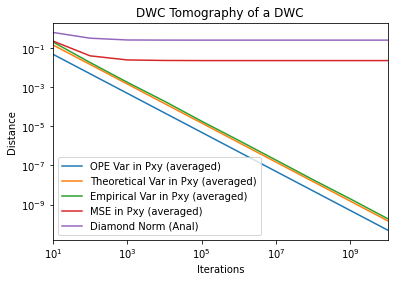

In [4]:
# %% DWC tomography of a DWC
d = 2
M = 1000# repeat for each N
noise_lev = 0.3
gamm = 0.7
N_vals = np.linspace(1,10, 10)
## Fixing one channel
Pxy = eig_e_corr(d,gamm)
Pxy.sort()
aaa = Pxy
Pxy = Pxy.reshape((d,d))
#print(Pxy)
######################
aaa.setflags(write=1)
aaa[aaa<0] = 0
aaa[aaa>1] = 1

###
idx_opers, rel_matrix = get_K(d)
exp_obs = np.reshape(rel_matrix*np.matrix(aaa).T,[int(len(rel_matrix)/d),int(d)]).tolist()
rel_inv = np.linalg.pinv(rel_matrix)
######################


var_Pxy = np.sum(aaa*(1-aaa))
N_vals = [round(10**ii) for ii in N_vals]
print(M*len(N_vals), 'total tasks')
dist_dist = np.zeros((M,len(N_vals))) # distance in distribution
norm_dist = np.zeros((M,len(N_vals))) # diamond norm distance
# emp_var = np.zeros((M,len(N_vals))) # empirical variance in sestimate of first element
theor_var = np.zeros((len(N_vals))) # theoritical variance in sestimate of first element
x_obs = list(map(DWC_tom_fast,[[exp_obs,N_vals[ii], rel_matrix, rel_inv, noise_lev, d] for ii in range(len(N_vals)) for kk in range(M)])) # Should be divided by d+1
################
for ii in range(len(N_vals)):
    theor_var[ii] =var_Pxy*len(idx_opers)/N_vals[ii]


d_norm_anal_v = list(map(d_norm_anal, [(Pxy,  x_obs[kk], d) 
                                   for kk in range(len(x_obs))]))



d_norm_anal_p = np.mean(np.reshape(d_norm_anal_v, [len(N_vals), M]), axis = 1) # plot d_norm

asd = list(map(empVar,[[x_obs, M, N_vals, kk] for kk in range(d**2)]))
emp_var2 = np.sum([asd[kk] for kk in range(d**2)],axis=0)

asd = list(map(mmse,[[x_obs, M, N_vals, kk,aaa] for kk in range(d**2)]))
mse_0 = np.sum([asd[kk] for kk in range(d**2)],axis = 0)

plt.figure()

plt.loglog(N_vals, theor_var/len(idx_opers), label="OPE Var in Pxy (averaged)")
plt.loglog(N_vals, theor_var, label="Theoretical Var in Pxy (averaged)")
plt.loglog(N_vals, emp_var2, label="Empirical Var in Pxy (averaged)")
plt.loglog(N_vals, mse_0, label="MSE in Pxy (averaged)")
#plt.loglog(N_vals, d_norm_p, label = "Diamond Norm (Opt)")
plt.loglog(N_vals, d_norm_anal_p, label = "Diamond Norm (Anal)")


mse_no_mit = mse_0
d_norm_no_mit = d_norm_anal_p

plt.xlim(N_vals[0], N_vals[-1])
plt.xlabel("Iterations")
plt.ylabel("Distance")
plt.title("DWC Tomography of a DWC")
plt.legend()
plt.show()

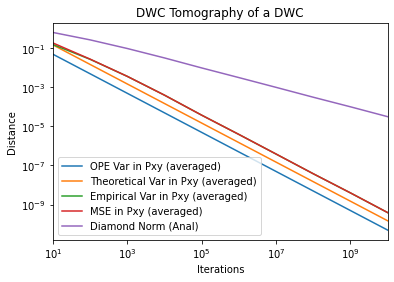

In [5]:
##### Noise mitigation
#weyl_oper = gen_weyl(d)

noise_correct = noise_lev

######################
## Miti + Correctio ##
######################
x_obs_corr = [kk/(1 - noise_correct) - noise_correct/((1 - noise_correct)*d**2) for kk in x_obs] # Only bias mitigation
x_obs_corr = [kk.clip(min = 0) for kk in x_obs_corr]
x_obs_corr = [kk/np.sum(kk) for kk in x_obs_corr]
######################
for ii in range(len(N_vals)):
    theor_var[ii] =var_Pxy*len(idx_opers)/N_vals[ii]


d_norm_anal_v = list(map(d_norm_anal, [(Pxy,  x_obs_corr[kk], d) 
                                   for kk in range(len(x_obs_corr))]))



d_norm_anal_p = np.mean(np.reshape(d_norm_anal_v, [len(N_vals), M]), axis = 1) # plot d_norm

asd = list(map(empVar,[[x_obs_corr, M, N_vals, kk] for kk in range(d**2)]))
emp_var2 = np.sum([asd[kk] for kk in range(d**2)],axis=0)

asd = list(map(mmse,[[x_obs_corr, M, N_vals, kk,aaa] for kk in range(d**2)]))
mse_0 = np.sum([asd[kk] for kk in range(d**2)],axis = 0)



plt.figure()

plt.loglog(N_vals, theor_var/len(idx_opers), label="OPE Var in Pxy (averaged)")
plt.loglog(N_vals, theor_var, label="Theoretical Var in Pxy (averaged)")
plt.loglog(N_vals, emp_var2, label="Empirical Var in Pxy (averaged)")
plt.loglog(N_vals, mse_0, label="MSE in Pxy (averaged)")
#plt.loglog(N_vals, d_norm_p, label = "Diamond Norm (Opt)")
plt.loglog(N_vals, d_norm_anal_p, label = "Diamond Norm (Anal)")


mse_mit_norm = mse_0
d_norm_mit_norm = d_norm_anal_p

plt.xlim(N_vals[0], N_vals[-1])
plt.xlabel("Iterations")
plt.ylabel("Distance")
plt.title("DWC Tomography of a DWC")
plt.legend()
plt.show()

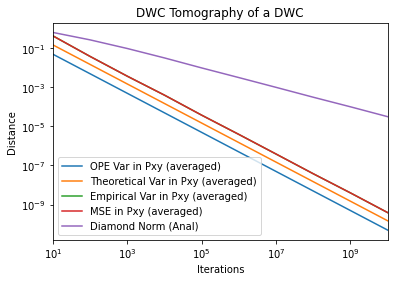

In [6]:
##### Noise mitigation

noise_correct = noise_lev

######################
## Mit - Correction ##
######################
x_obs_corr = [kk/(1 - noise_correct) - noise_correct/((1 - noise_correct)*d**2) for kk in x_obs] # Only bias mitigation
######################
for ii in range(len(N_vals)):
    theor_var[ii] =var_Pxy*len(idx_opers)/N_vals[ii]


d_norm_anal_v = list(map(d_norm_anal, [(Pxy,  x_obs_corr[kk], d) 
                                   for kk in range(len(x_obs_corr))]))


d_norm_anal_p = np.mean(np.reshape(d_norm_anal_v, [len(N_vals), M]), axis = 1) # plot d_norm

asd = list(map(empVar,[[x_obs_corr, M, N_vals, kk] for kk in range(d**2)]))
emp_var2 = np.sum([asd[kk] for kk in range(d**2)],axis=0)

asd = list(map(mmse,[[x_obs_corr, M, N_vals, kk,aaa] for kk in range(d**2)]))
mse_0 = np.sum([asd[kk] for kk in range(d**2)],axis = 0)



plt.figure()

plt.loglog(N_vals, theor_var/len(idx_opers), label="OPE Var in Pxy (averaged)")
plt.loglog(N_vals, theor_var, label="Theoretical Var in Pxy (averaged)")
plt.loglog(N_vals, emp_var2, label="Empirical Var in Pxy (averaged)")
plt.loglog(N_vals, mse_0, label="MSE in Pxy (averaged)")
#plt.loglog(N_vals, d_norm_p, label = "Diamond Norm (Opt)")
plt.loglog(N_vals, d_norm_anal_p, label = "Diamond Norm (Anal)")


mse_mit = mse_0
d_norm_mit = d_norm_anal_p

plt.xlim(N_vals[0], N_vals[-1])
plt.xlabel("Iterations")
plt.ylabel("Distance")
plt.title("DWC Tomography of a DWC")
plt.legend()
plt.show()

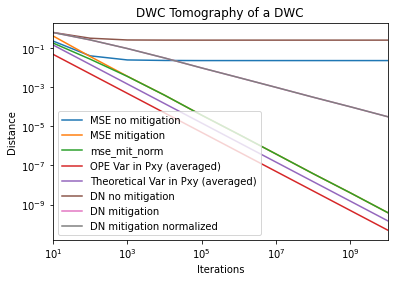

In [7]:

plt.figure()

plt.loglog(N_vals, mse_no_mit, label="MSE no mitigation")
plt.loglog(N_vals, mse_mit, label="MSE mitigation")
plt.loglog(N_vals, mse_mit_norm, label="mse_mit_norm")
plt.loglog(N_vals, theor_var/len(idx_opers), label="OPE Var in Pxy (averaged)")
plt.loglog(N_vals, theor_var, label="Theoretical Var in Pxy (averaged)")
#plt.loglog(N_vals, emp_var2, label="Empirical Var in Pxy (averaged)")
plt.loglog(N_vals, d_norm_no_mit, label = "DN no mitigation")
plt.loglog(N_vals, d_norm_mit, label = "DN mitigation")
plt.loglog(N_vals, d_norm_mit_norm, label = "DN mitigation normalized")

plt.xlim(N_vals[0], N_vals[-1])
plt.xlabel("Iterations")
plt.ylabel("Distance")
plt.title("DWC Tomography of a DWC")
plt.legend()
plt.show()